# Demonstration of the QLSAs workflow, following the qiskit patterns framework

In [37]:
# Set system path

from pathlib import Path
import sys


def find_repo_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for d in (p, *p.parents):
        if (d / ".git").exists() or (d / "pyproject.toml").exists() or (d / "src").exists():
            return d
    return p  # fallback


repo_root = find_repo_root()
print(repo_root)

# This repo uses a "src layout" (the Python package lives in <repo>/src/qlsas),
# but the repo is not installed as a package. Add <repo>/src to sys.path.
src_dir = repo_root / "src"
if src_dir.exists() and str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

# Also add the repo root so you can import top-level modules like
# `linear_systems_problems.random_matrix_generator`.
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

/Users/adrianharkness/QCOL_COPT/HHL/QLSAs


In [38]:
# Import QLSAs modules

from qlsas.qlsa.hhl import HHL
from qlsas.data_loader import StatePrep
from qlsas.transpiler import Transpiler
from qlsas.executer import Executer
from qlsas.post_processor import Post_Processor
from qlsas.solver import QuantumLinearSolver
from qlsas.refiner import Refiner
from linear_systems_problems.random_matrix_generator import generate_problem

# Import other modules
import numpy as np
import math
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

%config InlineBackend.figure_format = "retina"

## Step 0: **Define** the (classical) problem

In [39]:
prob = generate_problem(n=8, cond_number=5.0, sparsity=0.5, seed=0)
A, b = prob["A"], prob["b"]

A  = A / np.linalg.norm(b)
b = b / np.linalg.norm(b)

print(f"A: {A}")
print()
print(f"b: {b}")


A: [[ 1.25443337e+00 -1.04861115e-01 -4.04793036e-17  1.98064596e-02
  -5.70423574e-16 -2.60849077e-01 -1.51594382e-01 -1.15806717e-17]
 [-1.04861115e-01  2.23466620e+00 -3.37281869e-01 -2.98719127e-01
   5.01421052e-17 -5.97132489e-01  9.94485086e-16  3.34280701e-17]
 [-4.04793036e-17 -3.37281869e-01  1.87410588e+00  4.53911103e-01
  -2.56732302e-01 -1.67140351e-16 -1.83854386e-16  3.06937805e-01]
 [ 1.98064596e-02 -2.98719127e-01  4.53911103e-01  2.34633913e+00
   1.73303040e-01 -1.33712280e-16  7.60488595e-16 -8.02273682e-16]
 [-5.70423574e-16  5.01421052e-17 -2.56732302e-01  1.73303040e-01
   1.02563574e+00 -5.43206139e-17  4.02964939e-16 -6.33144014e-02]
 [-2.60849077e-01 -5.97132489e-01 -1.67140351e-16 -1.33712280e-16
  -5.43206139e-17  1.43280413e+00  4.99649356e-01 -1.67140351e-17]
 [-1.51594382e-01  9.94485086e-16 -1.83854386e-16  7.60488595e-16
   4.02964939e-16  4.99649356e-01  1.04259058e+00 -1.08641228e-16]
 [-1.15806717e-17  3.34280701e-17  3.06937805e-01 -8.02273682e-16


## Step 1: **Map** problem to quantum circuits and operators

In [40]:
hhl = HHL(
    state_prep = StatePrep(method='default'),
    readout = 'measure_x',
    #swap_test_vector = np.ones(len(b)) / np.linalg.norm(np.ones(len(b))),
    num_qpe_qubits = math.log2(len(b)),
    t0 = 2 * np.pi)

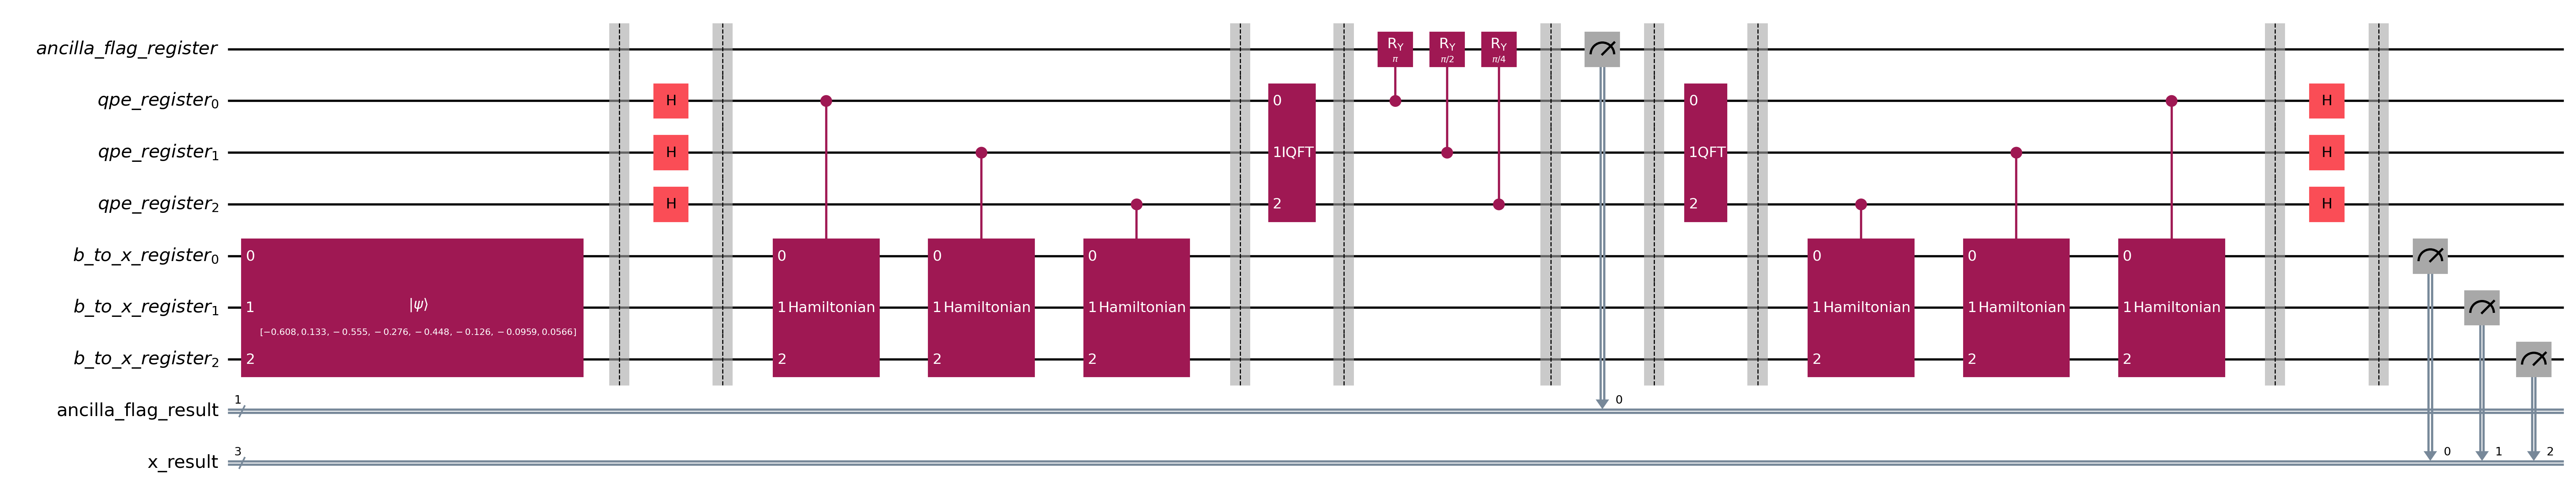

In [41]:
hhl_circuit = hhl.build_circuit(A, b)
hhl_circuit.draw(output='mpl', fold=-1)

## Step 2: **Optimize** for target hardware

In [42]:
service = QiskitRuntimeService(name="QLSAs")
service.backends()

[<IBMBackend('ibm_pittsburgh')>,
 <IBMBackend('ibm_boston')>,
 <IBMBackend('ibm_fez')>,
 <IBMBackend('ibm_torino')>,
 <IBMBackend('ibm_miami')>,
 <IBMBackend('ibm_marrakesh')>,
 <IBMBackend('ibm_kingston')>]

In [43]:
# Define a backend

# use a specific hardware backend
# backend = service.backend("ibm_boston")

# or use the least busy backend
# backend = service.least_busy(operational=True, min_num_qubits=hhl_circuit.num_qubits)
# print("Backend: ", backend)

# or use a simulator
# noiseless:
# backend = AerSimulator()

# noisy:
# Add depolarizing error to all single qubit u1, u2, u3 gates
noise_model = NoiseModel()
error_prob = .05
error = depolarizing_error(error_prob, 1)
noise_model.add_all_qubit_quantum_error(error, ["u1", "u2", "u3"])
backend = AerSimulator(noise_model=noise_model)

In [44]:
# Transpile the circuit

transpiler = Transpiler(circuit=hhl_circuit, backend=backend, optimization_level=3)
transpiled_hhl_circuit = transpiler.optimize()

print(f"2q-depth:        {transpiled_hhl_circuit.depth(lambda x: x.operation.num_qubits==2)}")
print(f"2q-size:         {transpiled_hhl_circuit.size(lambda x: x.operation.num_qubits==2)}")
print(f"Operator counts: {transpiled_hhl_circuit.count_ops()}")

2q-depth:        969
2q-size:         977
Operator counts: OrderedDict([('cx', 977), ('u3', 649), ('u1', 554), ('u2', 160), ('barrier', 9), ('measure', 4), ('initialize', 1)])


## Step 3: **Execute** on target hardware

In [45]:
executer = Executer()

result = executer.run(
    transpiled_circuit = transpiled_hhl_circuit, 
    backend = backend,
    shots = 100
    )

>>> Job ID: 48a6af22-c68c-4e47-8960-8ceea7bd894e
>>> Job Status: DONE      


## Step 4: **Process** result to obtain classical solution

In [46]:
processor = Post_Processor()
solution = processor.process(result, A, b)
solution

array([-0.31943828, -0.40406102, -0.28571429, -0.34992711, -0.40406102,
       -0.24743583, -0.37796447,  0.40406102])

## Wrapping steps 1-4 together in a solver:

In [47]:
hhl_solver = QuantumLinearSolver(
    qlsa = hhl,
    backend = backend,
    shots = 100,
    optimization_level = 3,
    executer = executer,
    post_processor = processor)

## Integrate **Iterative Refinement** to improve accuracy

IR Iteration: 0
>>> Job ID: cc1e6912-c8b3-4cb7-b868-89d072ccf853
>>> Job Status: DONE      
  residual: 0.7703, error: 0.7216, alpha: 0.4373

IR Iteration: 1
>>> Job ID: 53304604-9885-4fee-822f-8c2ac132690d
>>> Job Status: DONE      
  residual: 0.4985, error: 0.3568, alpha: 0.4477

IR Iteration: 2
>>> Job ID: 45c20634-4dc0-469c-aa2b-de07931ce447
>>> Job Status: DONE      
  residual: 0.3541, error: 0.2537, alpha: 0.4934

IR Iteration: 3
>>> Job ID: 502b97a8-ee14-4e12-aac3-c89f577aac6e
>>> Job Status: DONE      
  residual: 0.1749, error: 0.1034, alpha: 0.5004

IR Iteration: 4
>>> Job ID: 7e1117a9-5339-4c45-a9a9-6ab58979beb6
>>> Job Status: DONE      
  residual: 0.1607, error: 0.0942, alpha: 0.2886

IR Iteration: 5
>>> Job ID: b93a1a5e-1be9-48c4-9899-dde76f0453f9
>>> Job Status: DONE      
  residual: 0.1578, error: 0.0957, alpha: 0.1379

IR Iteration: 6
>>> Job ID: c59ad8a3-8d12-4933-acd4-35b91421a223
>>> Job Status: DONE      
  residual: 0.1169, error: 0.0537, alpha: 0.3779

IR Ite

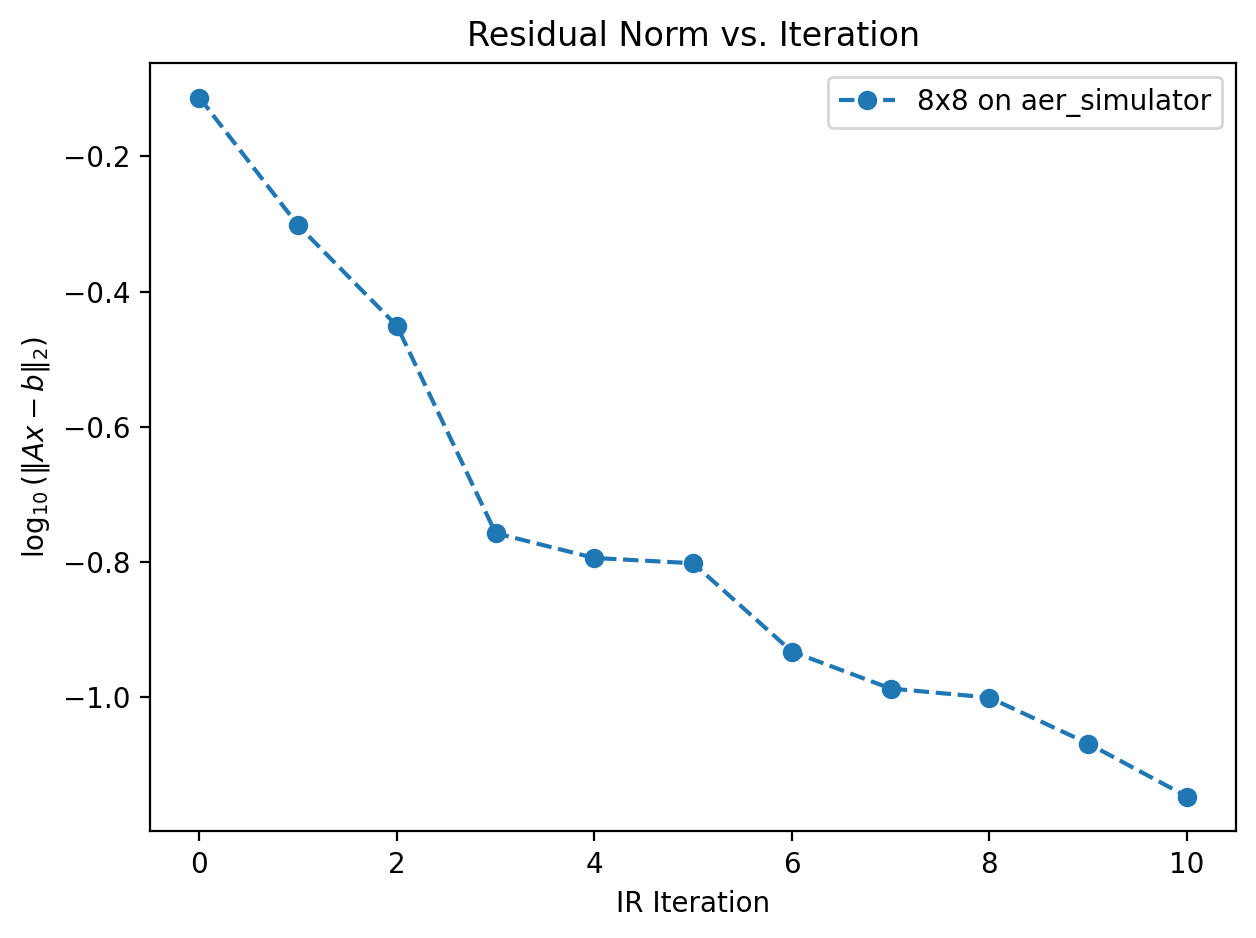

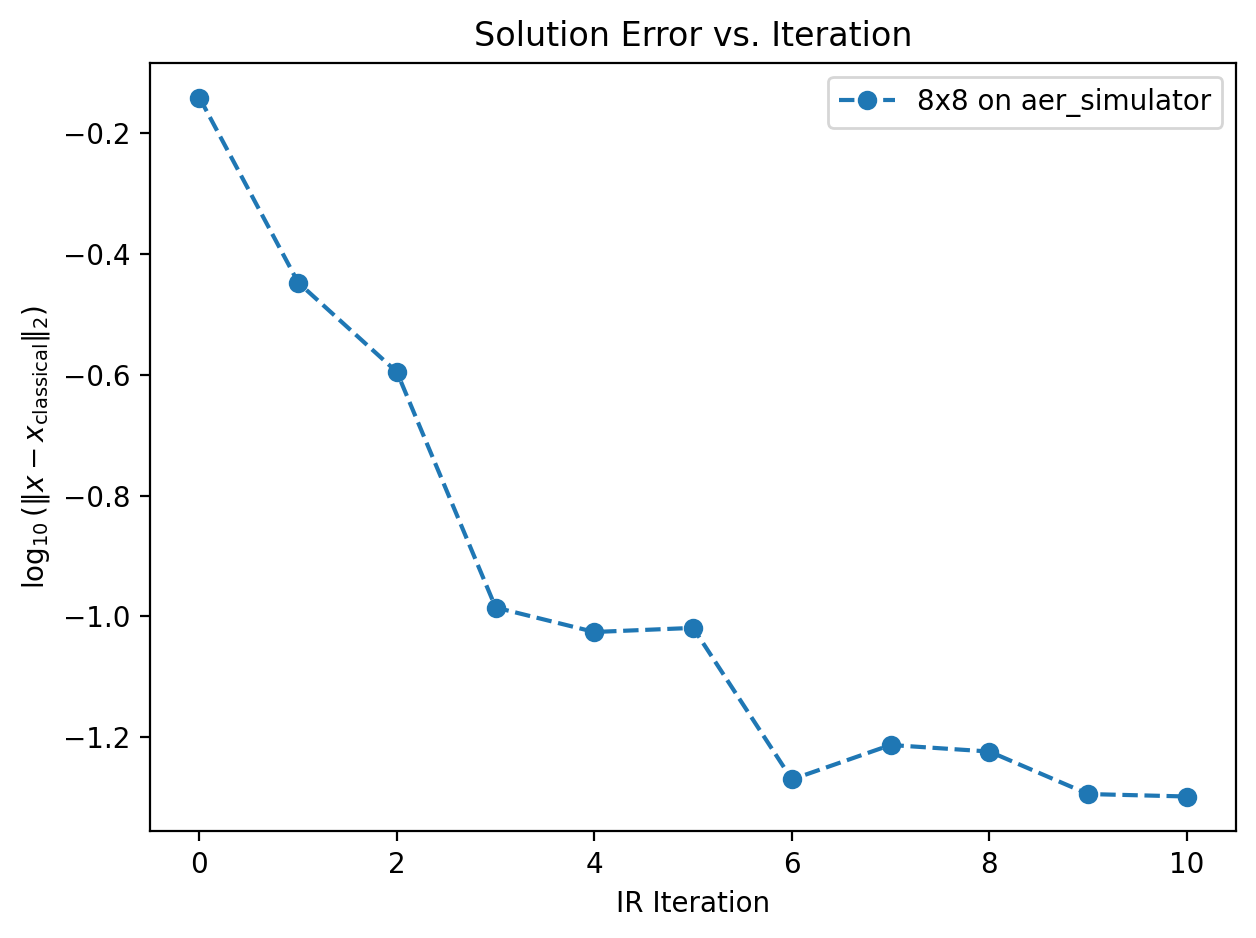

In [48]:
refiner = Refiner(A = A, b = b, solver = hhl_solver)
refined_solution = refiner.refine(precision = 1e-9, max_iter = 10, plot=True)